In [1]:
import scipy.io as io
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive
import json

In [2]:
%matplotlib notebook

In [3]:
with open('data/experimental_data.json', 'r') as fp:
    data = json.load(fp)
    
tips = list(data.keys())
tips = [tips[i] for i in np.argsort([np.min(data[tip]['gamma']) for tip in tips])]

In [4]:
#define analytical gamma formulas
gamma_nc = lambda H,R,c,d : -H*R/(12*np.sqrt(2)) * 1/(c-d)**(3/2)
gamma_tap = lambda H,R,E,c,d : -H*R/(6*np.sqrt(2)*np.pi)*(
    np.sqrt(d)/(c*(d-c)) - np.arctanh(np.sqrt((d-c)/d))/(d-c)**(3/2) + 2*np.sqrt(d)/c**2
    )+ E*np.sqrt(2*R)/4*d**2

gamma = lambda H,R,E,c,d : (np.heaviside(-d,1)*gamma_nc(H,R,c,d.astype('complex')) + 
                            np.heaviside(d,0)*gamma_tap(H,R,E,c,d.astype('complex')))

<IPython.core.display.Javascript object>


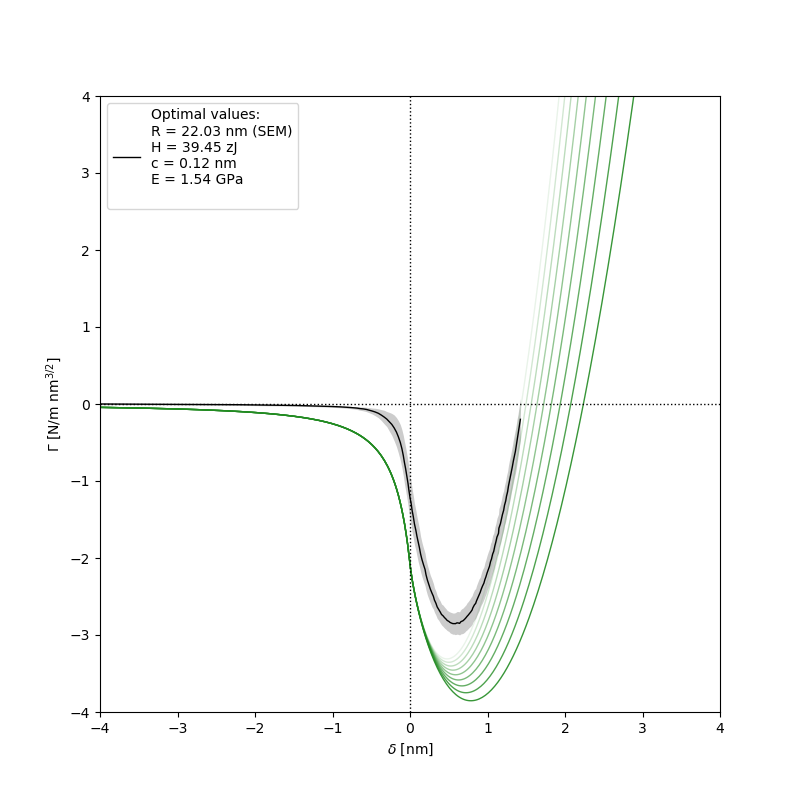

interactive(children=(IntSlider(value=60, description='H', max=1000, min=10, step=3), FloatSlider(value=10.0, …

In [6]:
fig, ax = plt.subplots(1,1, figsize=(8,8))

N=10 #how many lines are shown
d_list,y_list = [],[]

def update(H=60,R=10,E=1,c=0.17,dlim=4,ylim=4,tip=tips[1]):
    ax.cla()
    
    #make to right 
    H *= 1e-21
    R *= 1e-9
    E *= 1e9
    c *= 1e-9
    
    d_list.insert(0,np.linspace(-dlim*1e-9,dlim*1e-9,400))
    y_list.insert(0,gamma(H,R,E,c,d_list[0]))
    
    if len(y_list)>N: 
        del y_list[-1]
        del d_list[-1]
    
    for i in range(len(y_list)):
        ax.plot(d_list[i]*1e9, y_list[i]*1e9**(3/2), color='forestgreen', linewidth=1, alpha=1-(i+1)/N)
    
    #plot real data
    label = 'Optimal values:\n'
    label += 'R = ' + str(np.round(data[tip]['R_SEM']/1e-9,2)) + ' nm (SEM)\n'
    label += 'H = ' + str(np.round(data[tip]['H_opt']/1e-21,2)) + ' zJ\n'
    label += 'c = ' + str(np.round(data[tip]['c_opt']/1e-9,2)) + ' nm\n'
    label += 'E = ' + str(np.round(data[tip]['E_opt']/1e9,2)) + ' GPa\n'
    ax.plot(data[tip]['d_max'], data[tip]['gamma'], color='k', linewidth=1, label=label)
    ax.fill_between(data[tip]['d_max'], 
                    np.array(data[tip]['gamma'])-np.array(data[tip]['gamma_std']), 
                    np.array(data[tip]['gamma'])+np.array(data[tip]['gamma_std']), 
                    color='k', linewidth=0, alpha=0.2)
    
    #plot styling
    ax.axhline(0,linewidth=1,color='k',linestyle=':')
    ax.axvline(0,linewidth=1,color='k',linestyle=':')
    ax.set_xlabel('$\delta$ [nm]')
    ax.set_ylabel('$\Gamma$ [N/m nm$^{3/2}$]')
    ax.legend(loc=2)
    ax.set_xlim(-dlim,dlim)
    ax.set_ylim(-ylim,ylim)
    
    fig.canvas.draw()
    
    
interactive(update, H=(10,1000,3),R=(2,50,0.5),E=(0.4,40,0.1),c=(0.05,1,0.003), dlim=(1,10,1), tip=tips)